## Results of Host Prediction
**Model**: Transformer w/o convolution

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1024

**Classification**: Multi-class

**\# classes**: 10

**Dataset**: All viruses, all proteins, without duplicates (~19K)

**\# train samples** = 14,633

**\# test samples** = 3,659

In [22]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve

In [13]:
output_filepath = os.path.join(os.getcwd(), "..", "..","output\\raw\\uniref90\\20230510\\host_multi\\tf-emb_sincos-msl_1024-d_512-transformer-crossentropy_output.csv")

In [14]:
df = pd.read_csv(output_filepath, index_col=0)

In [15]:
df.head()

,Cattle,Desert warthog,Goat,Horse,Human,Lesser bandicoot rat,Others,Red junglefowl,Wood mouse,y_true,itr
0,0.103914,0.077629,0.083222,0.003940,0.048052,0.000236,0.530670,0.151303,0.001034,Others,0
1,0.000132,0.000155,0.000034,0.000013,0.998846,0.000003,0.000549,0.000026,0.000241,Human,0
2,0.000045,0.000006,0.000136,0.000121,0.998216,0.000726,0.000531,0.000200,0.000018,Human,0
3,0.000008,0.000004,0.000018,0.000003,0.999880,0.000002,0.000058,0.000005,0.000022,Human,0
4,0.000022,0.000007,0.000009,0.000012,0.999835,0.000001,0.000098,0.000007,0.000009,Human,0


In [43]:
cols = df.columns
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))

In [44]:
non_human_cols

['Goat',
 'Horse',
 'Others',
 'Wood mouse',
 'Lesser bandicoot rat',
 'Desert warthog',
 'Cattle',
 'Red junglefowl']

In [45]:
itrs = df[itr_col].unique()
itrs

array([0, 1, 2, 3, 4], dtype=int64)

In [50]:
def compute_auprc(df_itr, y_pred_columns, y_true_col):
    pr_curves = []
    auprcs = []
    for y_pred_column in y_pred_columns:
        precision, recall, _ = precision_recall_curve(y_true=df_itr[y_true_col].values, probas_pred=df_itr[y_pred_column].values, pos_label=y_pred_column)
        pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, "class": y_pred_column}))
        auprcs.append({"class": y_pred_column, "auprc": auc(recall, precision)})
    return pd.concat(pr_curves, ignore_index=True), pd.DataFrame(auprcs)

In [60]:
def compute_class_distribution(df, label_col, format=False):
    labels_counts = df[label_col].value_counts()
    n = labels_counts.sum()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k} ({v:.2f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [51]:
result = []
pr_curves = []
for itr in itrs:
    df_itr = df[df[itr_col] == itr]
    pr_curves_df, auprcs_df = compute_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
    pr_curves_df[itr_col] = itr
    auprcs_df[itr_col] = itr
    result.append(auprcs_df)
    pr_curves.append(pr_curves_df)

result_df = pd.concat(result, ignore_index=True)
pr_curves_df = pd.concat(pr_curves, ignore_index=True)
        
        

In [53]:
result_df.head(30)

,class,auprc,itr
0,Goat,0.839390,0
1,Horse,0.887659,0
2,Others,0.476289,0
3,Wood mouse,0.551230,0
4,Lesser bandicoot rat,0.968533,0
5,Desert warthog,0.854813,0
6,Cattle,0.272611,0
7,Red junglefowl,0.827309,0
8,Human,0.998129,0
9,Goat,0.770621,1


In [56]:
pr_curves_df.head()

,precision,recall,class,itr
0,0.107459,1.000000,Goat,0
1,0.106329,0.988235,Goat,0
2,0.106464,0.988235,Goat,0
3,0.106599,0.988235,Goat,0
4,0.106734,0.988235,Goat,0


In [62]:
metadata = compute_class_distribution(df_itr, y_true_col, format=True)
metadata

{'Human': 'Human (77.59%)',
 'Desert warthog': 'Desert warthog (5.47%)',
 'Lesser bandicoot rat': 'Lesser bandicoot rat (4.19%)',
 'Others': 'Others (3.98%)',
 'Horse': 'Horse (2.30%)',
 'Goat': 'Goat (2.23%)',
 'Red junglefowl': 'Red junglefowl (1.75%)',
 'Wood mouse': 'Wood mouse (1.49%)',
 'Cattle': 'Cattle (1.00%)'}

#### AUPRC for each class

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Goat (2.23%)'),
  Text(1, 0, 'Horse (2.30%)'),
  Text(2, 0, 'Others (3.98%)'),
  Text(3, 0, 'Wood mouse (1.49%)'),
  Text(4, 0, 'Lesser bandicoot rat (4.19%)'),
  Text(5, 0, 'Desert warthog (5.47%)'),
  Text(6, 0, 'Cattle (1.00%)'),
  Text(7, 0, 'Red junglefowl (1.75%)'),
  Text(8, 0, 'Human (77.59%)')])

<Figure size 432x288 with 0 Axes>

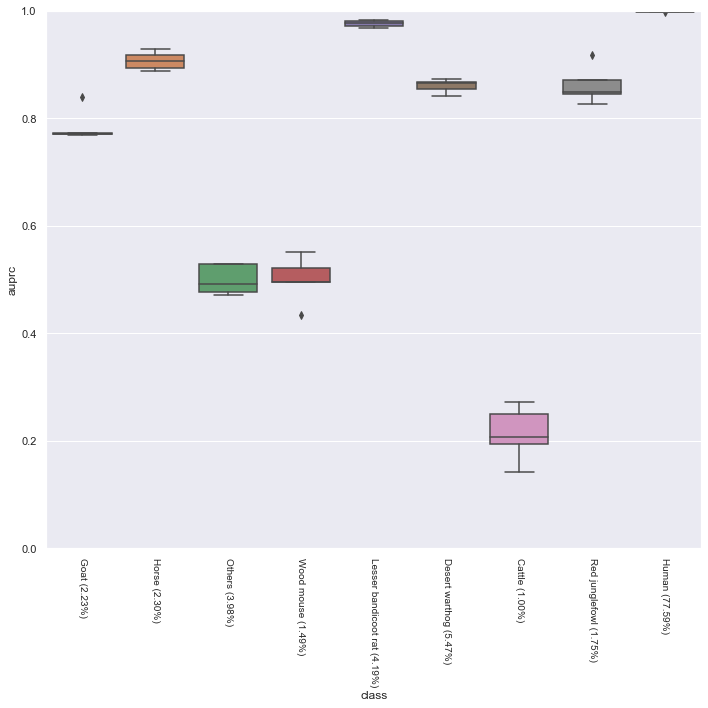

In [66]:
plt.clf()
sns.set_theme()

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['figure.autolayout'] = True
plt.figure(figsize=(10, 10))
ax = sns.boxplot(data=result_df, x="class", y="auprc")
ax.set_ylim(0, 1)
ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
plt.tight_layout()
plt.xticks(rotation=-90)


#### Precision Recall Curves

<Figure size 432x288 with 0 Axes>

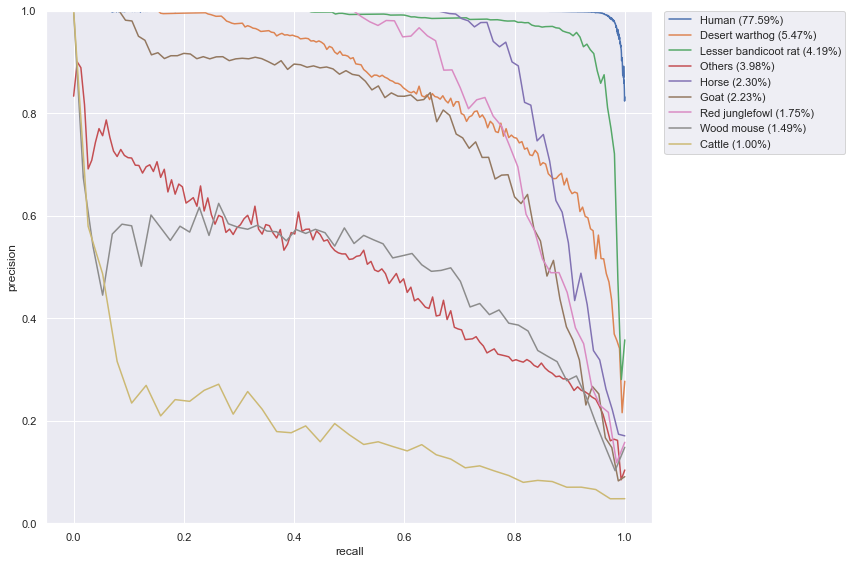

In [69]:
plt.clf()
sns.set_theme()
hue_order = None
if metadata is not None:
    pr_curves_df_metadata = pr_curves_df.replace({"class": metadata})
    hue_order = list(metadata.values())
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)

ax.set_ylim(0, 1)
plt.rcParams['xtick.labelsize'] = 8
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()